## Import module

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Environment initialization

In [2]:
# Taxi-v3 environment
env = gym.make("Taxi-v3", render_mode="ansi").env
state= env.reset()
rendered_env = env.render()
print(rendered_env)
print(state)
print(f'number of states: {env.observation_space.n}, action: {env.action_space.n}')

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+


(169, {'prob': 1.0, 'action_mask': array([1, 1, 1, 1, 0, 0], dtype=int8)})
number of states: 500, action: 6


## Helper function

In [4]:
# Selection function
def epsilon_selection(state,epsilon,q_table):
    if np.random.uniform(0, 1) < epsilon:
        action = env.action_space.sample() # Sample random action (exploration)
    else:      
        action = np.argmax(q_table[state]) # Select best known action (exploitation)
    return action

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def softmax_selection(state, q_table):
    action_probabilities = softmax(q_table[state])
    # randomly choose action according to the probability 
    action = np.random.choice(len(action_probabilities), p=action_probabilities)
    return action

def plot(cum_rewards, total_epochs):
    plt.figure(figsize=(14, 6)) 

    # Plot 1: Cumulative reward per episode
    plt.subplot(1, 2, 1)
    plt.plot(cum_rewards,label='Learning')
    plt.title("Accumulated Reward Over Episode(Learning)")
    plt.xlabel("Episodes")
    plt.ylabel("Accumulated Reward")
    plt.legend()
    
    # Plot 2: Number of epochs per episode
    plt.subplot(1, 2, 2)
    plt.plot(total_epochs,label='Learning')
    plt.title("Steps Per Episodes(Learning)")
    plt.xlabel("Episodes")
    plt.ylabel("steps")
    plt.legend()
    
    # Adjust layout and display the plot
    plt.tight_layout()  
    plt.show()

## Training the agent using Q-learning

Episode : 3500


===Training completed(Q-learning).===



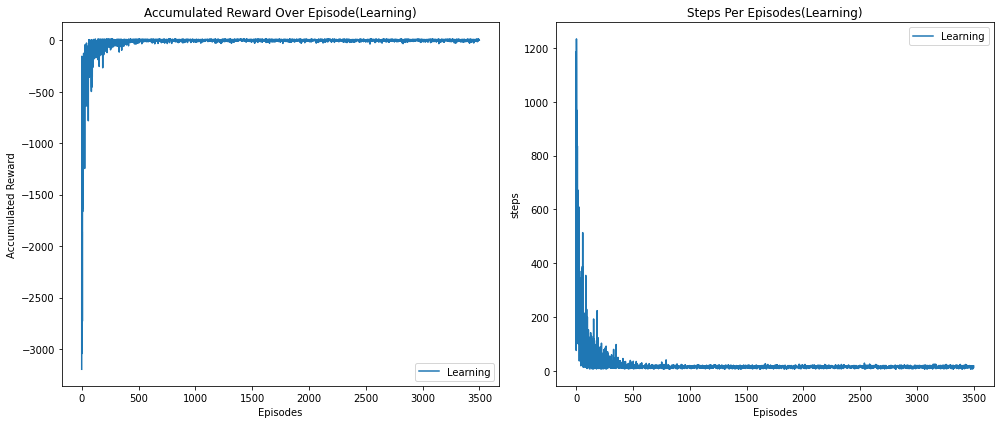

In [10]:
# Q-learning

def q_learning_agent(num_episodes):
    q_table_q_train = np.zeros([env.observation_space.n, env.action_space.n])
    # Hyperparameters
    alpha = 0.32 # Learning rate
    gamma = 0.98  # Discount rate
    epsilon = 0.35  # Exploration rate
    min_epsilon = 0.1  # Minimum exploration rate
    decay_rate = 0.99  # Decay rate for exploration rate

    # Output for plots
    accum_rewards = np.zeros([num_episodes])
    total_steps = np.zeros([num_episodes])

    for episode in range(1, num_episodes + 1):
        # Reset environment
        state, info = env.reset()
        step = 0 
        finish = False
        cum_reward = 0

        while not finish:
            # Action selection
            action = epsilon_selection(state,epsilon,q_table_q_train)
            next_state, reward, finish, _ , info = env.step(action) 
            
            # Calculate q-value and update the q-table
            old_q_value = q_table_q_train[state, action]
            next_max = np.max(q_table_q_train[next_state])
            q_table_q_train[state, action] +=  alpha * (reward + gamma * next_max - old_q_value)
            
            # count the reward and steps
            state = next_state
            step += 1
            cum_reward += reward
            total_steps[episode-1] = step
            accum_rewards[episode-1] = cum_reward
            
        # Decay epsilon
        epsilon = max(min_epsilon, epsilon * decay_rate)
        
        if episode % 100 == 0:
            clear_output(wait=True)
            print(f"Episode : {episode}")

    print("\n")
    print("===Training completed(Q-learning).===\n")
    # plot the picture
    plot(accum_rewards,total_steps)
    # save q-table for q-learning
    np.save("q_table_q_learning.npy", q_table_q_train)
 
# run the function given the number of episodes as parameter for Q-learning
q_learning_agent(3500)

## Performance test for Q-learning

In [13]:
# Test policy performance for Q-learning after training

def test_q_learning(num_episodes):
    q_table_q_learning = np.load("q_table_q_learning.npy")
    num_steps = 0
    num_illegally_dropoffs = 0
    max_steps_per_episode = 100
    #show the result of one episode
    target_episode = np.random.randint(num_episodes)  
    print(f'episode:  {target_episode} (Q-learning)')
    total_reward = 0
    for episode in range(num_episodes):
        # Initialize experience buffer
        state,_ = env.reset()
        step = 0 
        num_illegally_dropoffs = 0
        cum_reward = 0
        finish = False

        # limit the max_steps each episode to 100
        for i in range(max_steps_per_episode):
            if finish:
                break
            step += 1
        
            # greedy selection
            action = np.argmax(q_table_q_learning[state])
            state, reward, finish, _, _ = env.step(action)
            cum_reward += reward
            # print steps of a trained agent (taxi) based on Q-learnin algorithm.
            if episode == target_episode:
                print(env.render())
                print(f'Step: {step-1}')
                print(f'State: {state}, Action: {action}, Reward: {reward}, Total Accumalated Reward: {cum_reward}')
                print()
                
            if reward == -10:
                num_illegally_dropoffs += 1

        # total steps and reward
        num_steps += step
        total_reward += cum_reward

    # Print final results
    print("\n") 
    print(f"Test results after {num_episodes} episodes:")
    print(f"Average number of illegally dropoffs per episode: {num_illegally_dropoffs / num_episodes}")
    print(f"Average number of steps per episode: {num_steps / num_episodes}")
    print(f"Average accumulated reward per episode: {total_reward / num_episodes}")

# run the test function for Q-learning
test_q_learning(200)

episode:  94 (Q-learning)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

Step: 0
State: 232, Action: 1, Reward: -1, Total Accumalated Reward: -1

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

Step: 1
State: 252, Action: 2, Reward: -1, Total Accumalated Reward: -2

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

Step: 2
State: 272, Action: 2, Reward: -1, Total Accumalated Reward: -3

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

Step: 3
State: 372, Action: 0, Reward: -1, Total Accumalated Reward: -4

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

Step: 4
State: 472, Action: 0, Reward: -1, Total Accumalated Reward: -5

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)

Step: 5
State: 476, Action: 4, Reward: -

## Training the agent using Sarsa

Episode #: 3500


===Training completed(SARSA).===



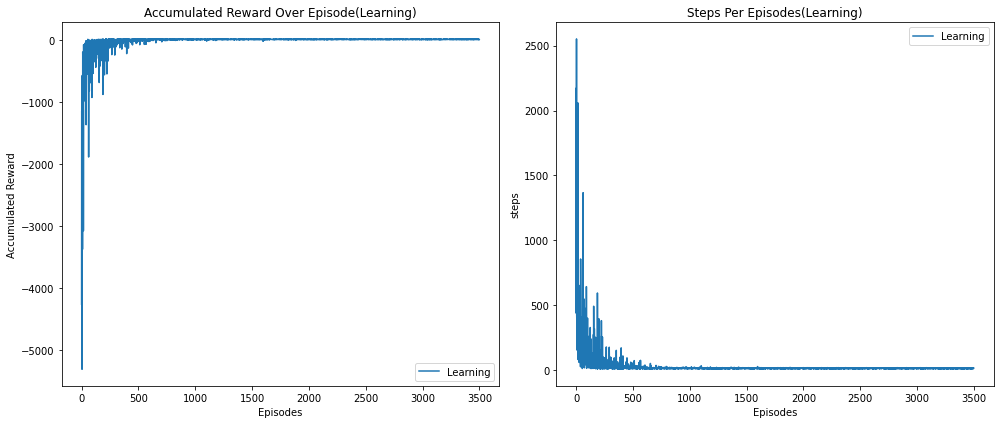

In [15]:
# Sarsa
# Test policy performance for Sarsa after training

def sarsa_agent(num_episodes):
    q_table_sarsa_train = np.zeros([env.observation_space.n, env.action_space.n])

    alpha = 0.3 # Learning rate
    gamma = 0.97  # Discount rate
    epsilon = 0.3  # Exploration rate
    min_epsilon = 0.1  # Minimum exploration rate
    decay_rate = 0.99  # Decay rate for exploration rate
    
    # Output for plots
    accum_reward = np.zeros([num_episodes])
    total_steps = np.zeros([num_episodes])

    for episode in range(1, num_episodes+1):
        # Reset environment
        state, info = env.reset()
        step = 0 
        finish = False
        cum_reward = 0
        action = softmax_selection(state,q_table_sarsa_train)

        while not finish:
            # update the q-table
            next_state, reward, finish, _ , info = env.step(action) 
            next_action = softmax_selection(next_state,q_table_sarsa_train)

            old_q_value = q_table_sarsa_train[state, action]
            q_table_sarsa_train[state, action] += alpha * (reward + gamma * q_table_sarsa_train[next_state, next_action] - old_q_value)

            # update the state and action, calculate the steps and reward
            state = next_state
            action = next_action
            step += 1
            cum_reward += reward
            total_steps[episode-1] = step
            accum_reward[episode-1] = cum_reward
        
        # Decay epsilon
        epsilon = max(min_epsilon, epsilon * decay_rate)
        if episode % 100 == 0:
            clear_output(wait=True)
            print(f"Episode #: {episode}")

    print("\n")
    print("===Training completed(SARSA).===\n")
    # plot the picture
    plot(accum_reward,total_steps)
    # save the q-table
    np.save("q_table_sarsa.npy", q_table_sarsa_train)

# run the function given the number of episodes as parameter for SARSA
sarsa_agent(3500)

In [17]:
# Test policy performance for Q-learning after training

def test_sarsa(num_episodes):
    q_table_sarsa = np.load("q_table_sarsa.npy")
    num_steps = 0
    num_illegally_dropoffs = 0
    max_steps_per_episode = 100
    
    #show the result of one episode
    target_episode = np.random.randint(num_episodes)  
    print(f'episode:  {target_episode} (SARSA)')

    total_reward = 0
    for episode in range(num_episodes):
        # Initialize experience buffer
        state,_ = env.reset()
        step = 0 
        num_illegally_dropoffs = 0
        cum_reward = 0
        finish = False

        # limit the max_steps each episode to 100
        for i in range(max_steps_per_episode):
            # if achieve the goal successfully, break
            if finish:
                break
            
            # greedy selection
            action = np.argmax(q_table_sarsa[state])
            state, reward, finish, _, _ = env.step(action)
            cum_reward += reward
            
            # print steps of a trained agent (taxi) based on Q-learnin algorithm.
            if episode == target_episode:
                print(env.render())
                print(f'Step: {step-1}')
                print(f'State: {state}, Action: {action}, Reward: {reward}, Total Accumalated Reward: {cum_reward}')
                print()
                
            if reward == -10:
                num_illegally_dropoffs += 1
            step += 1
            
        # total steps and reward
        num_steps += step
        total_reward += cum_reward

    # Print final results
    print("\n") 
    print(f"Test results after {num_episodes} episodes(sarsa):")
    print(f"Average number of illegally dropoffs per episode(sarsa): {num_illegally_dropoffs / num_episodes}")
    print(f"Average number of steps per episode(sarsa): {num_steps / num_episodes}")
    print(f"Average accumulated reward per episode(sarsa): {total_reward / num_episodes}")
    
# run the test function for SARSA
test_sarsa(200)

episode:  70 (SARSA)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)

Step: -1
State: 478, Action: 4, Reward: -1, Total Accumalated Reward: -1

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : |_: |
|Y| : |B: |
+---------+
  (North)

Step: 0
State: 378, Action: 1, Reward: -1, Total Accumalated Reward: -2

+---------+
|R: | : :G|
| : | : : |
| : : :_: |
| | : | : |
|Y| : |B: |
+---------+
  (North)

Step: 1
State: 278, Action: 1, Reward: -1, Total Accumalated Reward: -3

+---------+
|R: | : :G|
| : | : : |
| : :_: : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

Step: 2
State: 258, Action: 3, Reward: -1, Total Accumalated Reward: -4

+---------+
|R: | : :G|
| : | : : |
| :_: : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

Step: 3
State: 238, Action: 3, Reward: -1, Total Accumalated Reward: -5

+---------+
|R: | : :G|
| : | : : |
|_: : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

Step: 4
State: 218, Action: 3, Reward: -1, To